<a href="https://colab.research.google.com/github/KidsareBornStars/Study/blob/main/Balls_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
url="https://www.kaggle.com/datasets/gpiosenka/balls-image-classification/download?datasetVersionNumber=3"

In [2]:
cd

/root


In [5]:
# target file들이 있는 directory로 이동
%cd /content/drive/MyDrive/balls 

/content/drive/MyDrive/balls


In [6]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn 
import torch.utils.data as data
from torchvision import transforms, datasets
import torch.optim as optim
from torchsummary import summary

In [7]:
base_dir = "/content/drive/MyDrive/balls"

In [8]:
train_dir = os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"test")
valid_dir = os.path.join(base_dir,"valid")

In [9]:
balls = pd.read_csv("balls.csv")
classes = pd.read_csv("class_dict.csv")

In [12]:
balls

,filepaths,labels,data set
0,train/baseball/001.jpg,baseball,train
1,train/baseball/002.jpg,baseball,train
2,train/baseball/003.jpg,baseball,train
3,train/baseball/004.jpg,baseball,train
4,train/baseball/005.jpg,baseball,train
...,...,...,...
3306,valid/wrecking ball/1.jpg,wrecking ball,valid
3307,valid/wrecking ball/2.jpg,wrecking ball,valid
3308,valid/wrecking ball/3.jpg,wrecking ball,valid
3309,valid/wrecking ball/4.jpg,wrecking ball,valid


In [11]:
classes # class들 보기

,class_index,class,height,width,scale by
0,0,baseball,128,128,1
1,1,basketball,128,128,1
2,2,beachballs,128,128,1
3,3,billiard ball,128,128,1
4,4,bowling ball,128,128,1
5,5,brass,128,128,1
6,6,buckeyballs,128,128,1
7,7,cannon ball,128,128,1
8,8,cricket ball,128,128,1
9,9,eyeballs,128,128,1


In [13]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128))]) # 1~255의 rgb를 0~1로 normalize + classes보면 있는 사이즈 그대로 맞추기

In [14]:
# folder를 dataset으로 사용
train_data = datasets.ImageFolder(root=train_dir, transform = transform) 
test_data = datasets.ImageFolder(root=test_dir, transform = transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform = transform)

In [15]:
train_data[0][0].shape # transform이 잘 되었는지 확인

torch.Size([3, 128, 128])

In [16]:
len(train_data) # train_data의 갯수 확인

3051

In [17]:
import random
def show_image(x):
    x=x.permute(1,2,0) # height,width,channel의 순서로 변경
    plt.imshow(x)

0


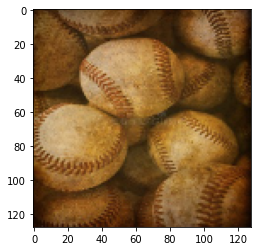

In [23]:
# random plotting
a = random.choice(range(3051))
show_image(train_data[a][0])
print(train_data[a][1])

In [24]:
# train_loader는 shuffle을 True, 나머지는 False
train_loader = data.DataLoader(train_data,64,True) 
test_loader = data.DataLoader(test_data,64,False)
valid_loader = data.DataLoader(valid_data,64,False)

In [25]:
# loader가 잘 생성되었는지 확인
x,y=next(iter(test_loader))
x.shape,len(y)

(torch.Size([64, 3, 128, 128]), 64)

## Normal CNN

In [26]:
# Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,8,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.fc = nn.Sequential(
            nn.Linear(8*32*32,32),
            nn.ReLU(),
            nn.Linear(32,26))
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [27]:
model = CNN()

In [28]:
# classification -> CrossEntropyLoss
# optimizer = Adam사용
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [29]:
# number of parameters 공부
summary(model,input_size=(3,128,128),batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 128, 128]             448
              ReLU-2         [64, 16, 128, 128]               0
         MaxPool2d-3           [64, 16, 64, 64]               0
            Conv2d-4            [64, 8, 64, 64]           1,160
              ReLU-5            [64, 8, 64, 64]               0
         MaxPool2d-6            [64, 8, 32, 32]               0
            Linear-7                   [64, 32]         262,176
              ReLU-8                   [64, 32]               0
            Linear-9                   [64, 26]             858
Total params: 264,642
Trainable params: 264,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.00
Forward/backward pass size (MB): 324.04
Params size (MB): 1.01
Estimated Total Size (MB): 337.05
--------------------------------------

In [30]:
len(train_loader.dataset)/64 # batch_size에 따라 몇번의 학습이 이루어지는지

47.671875

In [31]:
def train(epoch):
    model.train()

    train_loss = 0
    correct = 0
    for i, (input,label) in enumerate(train_loader):
        output = model(input)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (output.argmax(dim=1) == label).type(torch.float).sum().item()
        # 10번의 배치를 학습할 때마다 출력
        if (i+1)%10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] \tLoss: {:.3f} \tAccuracy: {:.2f}%'.format(
            epoch+1,
            (i+1) * len(input),
            len(train_loader.dataset),
            100. * (i+1) / len(train_loader),
            loss.item(),
            100. * correct / ((i+1) * len(input))))

In [32]:
def test(data_loader):
    model.eval()

    test_loss =0
    correct = 0
    for input,label in data_loader:
        output = model(input)

        test_loss += criterion(output,label).item()
        correct += (output.argmax(dim=1)==label).type(torch.float).sum().item()

    test_loss /= len(test_loader)
    accuracy  = 100. * correct / len(valid_loader.dataset)

    print(f"\nTest set: Average loss: {test_loss:.2f}, Accuracy: {accuracy:.0f}%\n") 

In [33]:
# 특정 epoch부터 overfitting이 일어나는 것을 확인할 수 있다
model = CNN()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
for epoch in range(15):
    train(epoch)
    test(valid_loader)

Train Epoch: 1 [640/3051 (21%)] 	Loss: 3.240 	Accuracy: 4.06%
Train Epoch: 1 [1280/3051 (42%)] 	Loss: 3.209 	Accuracy: 6.02%
Train Epoch: 1 [1920/3051 (62%)] 	Loss: 3.003 	Accuracy: 7.76%
Train Epoch: 1 [2560/3051 (83%)] 	Loss: 2.895 	Accuracy: 9.06%

Test set: Average loss: 3.06, Accuracy: 15%

Train Epoch: 2 [640/3051 (21%)] 	Loss: 2.718 	Accuracy: 20.31%
Train Epoch: 2 [1280/3051 (42%)] 	Loss: 2.412 	Accuracy: 22.58%
Train Epoch: 2 [1920/3051 (62%)] 	Loss: 2.593 	Accuracy: 26.04%
Train Epoch: 2 [2560/3051 (83%)] 	Loss: 2.425 	Accuracy: 27.15%

Test set: Average loss: 2.68, Accuracy: 35%

Train Epoch: 3 [640/3051 (21%)] 	Loss: 1.993 	Accuracy: 40.78%
Train Epoch: 3 [1280/3051 (42%)] 	Loss: 1.996 	Accuracy: 41.48%
Train Epoch: 3 [1920/3051 (62%)] 	Loss: 1.709 	Accuracy: 42.34%
Train Epoch: 3 [2560/3051 (83%)] 	Loss: 2.098 	Accuracy: 42.89%

Test set: Average loss: 2.54, Accuracy: 38%

Train Epoch: 4 [640/3051 (21%)] 	Loss: 1.538 	Accuracy: 47.03%
Train Epoch: 4 [1280/3051 (42%)] 	Loss

##Reducing Channels

In [34]:
# Overfitting 해결을 위하여 채널 수를 줄여봄
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,8,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8,4,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.fc = nn.Sequential(
            nn.Linear(4*32*32,32),
            nn.ReLU(),
            nn.Linear(32,26))
    
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [46]:
summary(CNN2(),(3,128,128),64) # parameter 수도 줄어든 것을 알 수 있다

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 8, 128, 128]             224
              ReLU-2          [64, 8, 128, 128]               0
         MaxPool2d-3            [64, 8, 64, 64]               0
            Conv2d-4            [64, 4, 64, 64]             292
              ReLU-5            [64, 4, 64, 64]               0
         MaxPool2d-6            [64, 4, 32, 32]               0
            Linear-7                   [64, 32]         131,104
              ReLU-8                   [64, 32]               0
            Linear-9                   [64, 26]             858
Total params: 132,478
Trainable params: 132,478
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 12.00
Forward/backward pass size (MB): 162.04
Params size (MB): 0.51
Estimated Total Size (MB): 174.55
--------------------------------------

In [ ]:
# 유의미하게 overfitting을 해결하지는 못하는 것 같다
model = CNN2()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
for epoch in range(15):
    train(epoch)
    test(valid_loader)

##CNN with Batch Normalization and Dropout

In [60]:
# Batch Normalization과 Dropout을 적용해보았다
class CNN_with_BN_DO(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,8,3,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2,2))
        self.fc = nn.Sequential(
            nn.Linear(8*32*32,32),
            nn.ReLU(),
            nn.Linear(32,26))
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [61]:
summary(CNN_with_BN_DO(),(3,128,128),64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 128, 128]             448
       BatchNorm2d-2         [64, 16, 128, 128]              32
              ReLU-3         [64, 16, 128, 128]               0
           Dropout-4         [64, 16, 128, 128]               0
         MaxPool2d-5           [64, 16, 64, 64]               0
            Conv2d-6            [64, 8, 64, 64]           1,160
       BatchNorm2d-7            [64, 8, 64, 64]              16
              ReLU-8            [64, 8, 64, 64]               0
           Dropout-9            [64, 8, 64, 64]               0
        MaxPool2d-10            [64, 8, 32, 32]               0
           Linear-11                   [64, 32]         262,176
             ReLU-12                   [64, 32]               0
           Linear-13                   [64, 26]             858
Total params: 264,690
Trainable params:

In [62]:
# 역시나 Overfitting이 심하다
model = CNN_with_BN_DO()
optimizer = optim.Adam(model.parameters(),lr=1e-3)
for epoch in range(15):
    train(epoch)
    test(valid_loader)

Train Epoch: 1 [640/3051 (21%)] 	Loss: 2.925 	Accuracy: 12.50%
Train Epoch: 1 [1280/3051 (42%)] 	Loss: 3.071 	Accuracy: 13.44%
Train Epoch: 1 [1920/3051 (62%)] 	Loss: 2.715 	Accuracy: 15.42%
Train Epoch: 1 [2560/3051 (83%)] 	Loss: 2.909 	Accuracy: 18.20%

Test set: Average loss: 2.91, Accuracy: 19%

Train Epoch: 2 [640/3051 (21%)] 	Loss: 2.824 	Accuracy: 28.28%
Train Epoch: 2 [1280/3051 (42%)] 	Loss: 2.365 	Accuracy: 28.75%
Train Epoch: 2 [1920/3051 (62%)] 	Loss: 2.530 	Accuracy: 30.42%
Train Epoch: 2 [2560/3051 (83%)] 	Loss: 2.287 	Accuracy: 30.94%

Test set: Average loss: 2.53, Accuracy: 32%

Train Epoch: 3 [640/3051 (21%)] 	Loss: 2.247 	Accuracy: 35.78%
Train Epoch: 3 [1280/3051 (42%)] 	Loss: 2.167 	Accuracy: 36.80%
Train Epoch: 3 [1920/3051 (62%)] 	Loss: 2.078 	Accuracy: 38.54%
Train Epoch: 3 [2560/3051 (83%)] 	Loss: 2.207 	Accuracy: 39.34%

Test set: Average loss: 2.12, Accuracy: 35%

Train Epoch: 4 [640/3051 (21%)] 	Loss: 1.975 	Accuracy: 47.97%
Train Epoch: 4 [1280/3051 (42%)] 	